In [102]:
# adds parent dir to python path
import sys
sys.path.insert(0, '..')

#system lib
import os
import json

# 3rd party lib
import numpy as np
#import matplotlib
#import matplotlib.pyplot as plt
#%matplotlib notebook
#matplotlib.rcParams.update({'font.size': 22})
#from bqplot import pyplot as plt

import matplotlib.pyplot as plt
%matplotlib inline

# astro lib
from astropy.io import fits
import sep

# my lib
import ImageTools as it
import DataTools as dt
from gphelper import GPHelper

from importlib import reload

import warnings
warnings.filterwarnings('ignore')


from multiprocessing import Pool

In [111]:
def make_nonnegative(img):
    epsilon = np.abs(img.min()) + 1e-3
    img[img<=0] = img[img>0].min()
    return img

def get_random_spheroids(num=10, with_ids=False):
    with open('../spheroids', 'r') as f:
        spheroids = np.array(f.readlines())
    
    if num==-1:
        num = len(spheroids)
    
    selected = np.random.choice(spheroids, num, replace=False)
    
    data_dir = os.path.join(os.getenv('HOME'), 'Documents/astro_data/orig_images')
    fmask = 'GDS_{}_{}.fits'
    f_string = os.path.join(data_dir, fmask)

    sources = []
    for s in selected:
        img = fits.getdata(f_string.format(s.strip(), 'h'))
        segmap = fits.getdata(f_string.format(s.strip(), 'segmap'))
        img_id = int(s.split('_')[1])
        sources.append((img.copy(), segmap.copy(), img_id))
        del img 
        del segmap
    
    if with_ids:
        return list(zip(selected, sources))
    else:
        return sources

# Petrosian Helpers ----------------------------------------------------------
def one_over_eta(rs, fs, R):
    return ((np.pi*R**2) / (np.sum(fs[rs<=R]))) * fs[rs==R]

def petrosian_radius(rs, fs):
    #r_candidates = np.array([one_over_eta(rs, fs, R) for R in rs])
    r_candidates = np.array([fs[rs==r]/fs[rs<=r].mean() for r in rs]).flatten()
    r_candidates = r_candidates[rs<12.5]
    
    return rs[np.square(r_candidates-0.2).argmin()]

def petrosian_flux(rs, fs, R_p):
    return np.sum(fs[rs<=2*R_p])

def R_x(rs, fs, x):
    x /= 100
    sum_ratio = np.cumsum(fs)/np.sum(fs)
    return rs[np.square(sum_ratio-x).argmin()]

def petrosian_Re(R_50, R_90):
    P_3 = 8e-6
    P_4 = 8.47
    R_ratio = min(R_90/R_50, 3.8)
    return R_50 / (1 - (P_3 * (R_ratio)**P_4))

def get_rs_and_fs(img, src_map):
    cx, cy = it.img_center(img, src_map)
    xs, ys = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]).T)
    rs = np.sqrt(np.square(xs-cx)+np.square(ys-cy))
    
    rs = rs.flatten()
    fs = img.flatten()
    sorted_rs = np.argsort(rs)
    
    rs = rs[sorted_rs]
    fs = fs[sorted_rs]
    
    return rs, fs

def get_re(img, src_map):
    rs, fs = get_rs_and_fs(img, src_map)
    
    R_p = petrosian_radius(rs, fs)
    F_p = petrosian_flux(rs, fs, R_p)
    p_mask = rs <= 2*R_p
    
    _rs = rs[p_mask]
    _fs = fs[p_mask]

    R_50 = R_x(_rs, _fs, 50)
    R_90 = R_x(_rs, _fs, 90)

    re = petrosian_Re(R_50, R_90)
    re_idx = np.square(_rs-re).argmin()
    
    return rs[re_idx], rs, fs

def get_re(rsfs):
    rs, fs = rsfs
    
    R_p = petrosian_radius(rs, fs)
    F_p = petrosian_flux(rs, fs, R_p)
    p_mask = rs <= 2*R_p
    
    _rs = rs[p_mask]
    _fs = fs[p_mask]

    R_50 = R_x(_rs, _fs, 50)
    R_90 = R_x(_rs, _fs, 90)

    re = petrosian_Re(R_50, R_90)
    re_idx = np.square(_rs-re).argmin()
    
    return rs[re_idx]

# Petrosian Helpers ----------------------------------------------------------

def denoise(img, segmap, img_id):
    noise_bank = img[segmap==0].flatten()
    other_source = np.logical_and(segmap!=0, segmap!=img_id)
    np.place(img, other_source, noise_bank)
    
    array_sep_likes = img.byteswap().newbyteorder()
    bkg = sep.Background(img.newbyteorder('='), mask=segmap==img_id, bw=10, bh=10)
    img = img-bkg
    
    return img

# https://ned.ipac.caltech.edu/level5/March05/Graham/Graham2.html
def sersic(x):
    def b(n):
        return 1.9992*n-0.3271

    def I(r):
        """Assuming that I_e=1.0 and that R_e=1.0"""
        n = 4
        return np.exp(-b(n) * (np.power(r, 1/n)  - 1))

    return I(x)

In [13]:
_id, (img, segmap, img_id) = get_random_spheroids(num=1, with_ids=True)[0]
img = denoise(img, segmap, img_id)
plt.title(_id)
plt.imshow(img, cmap='gray')


In [20]:
rs, fs = get_rs_and_fs(img, segmap==img_id)

str = 'r, I(r)\n'
for r, f in zip(rs, fs):
    str += f'{r},{f}\n'
    
with open('ascii_rsfs.csv', 'w') as f:
    f.write(str)

In [9]:
rs, fs = [], []
with open('ascii_rsfs.csv', 'r') as f:
    for line in f:
        if 'I(r)' in line:
            continue
        nums = line.split(' ')
        rs.append(float(nums[0]))
        fs.append(float(nums[1]))
        
rs = np.array(rs)
fs = np.array(fs)

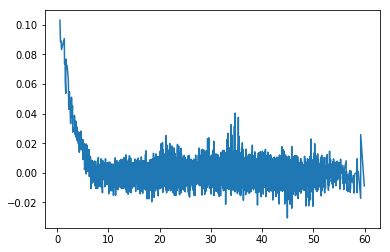

In [28]:
plt.plot(rs, fs)

In [71]:
%%time
dR=0.05*(rs.max()-rs.min())
print(dR)
f_smooth = dt.loessc_p(rs,fs,dx=dR, pnum=2)

2.96965003047
CPU times: user 404 ms, sys: 144 ms, total: 548 ms
Wall time: 2.44 s


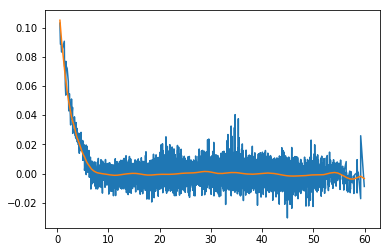

In [30]:
plt.plot(rs, fs)
plt.plot(rs, f_smooth)

In [41]:
(f_smooth<0).sum()

3795

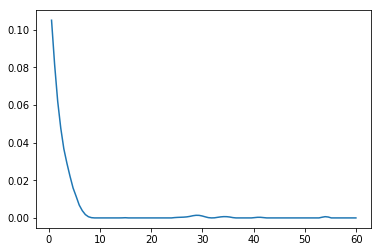

In [42]:
num_interp = 100
interp_rs = np.linspace(rs.min(), rs.max(), num_interp)
interp_fs = np.interp(interp_rs, rs, f_smooth)
interp_fs[interp_fs<0] = 0

plt.plot(interp_rs, interp_fs)

In [44]:
L = np.zeros(num_interp)
L[0] = np.pi*interp_rs[0]**2  * interp_fs[0]
for i in range(1,num_interp,1):
    L[i] = L[i-1] + np.pi*(interp_rs[i]**2 - interp_rs[i-1]**2)*interp_fs[i]

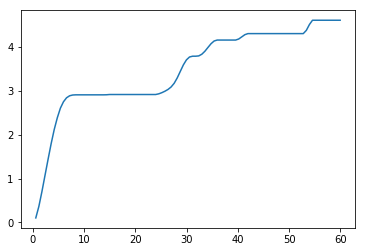

In [45]:
plt.plot(interp_rs, L)

In [48]:
A = np.pi * interp_rs**2

(0, 10)

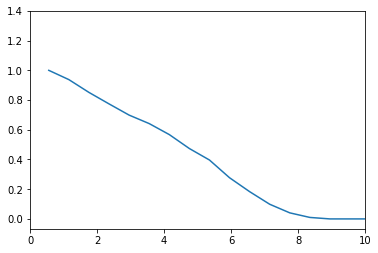

In [51]:
etas = interp_fs*A/L
plt.plot(interp_rs, etas)
plt.xlim([0,10])

In [54]:
eta_idx = np.square(etas[interp_rs<10]-0.2).argmin()
interp_rs[eta_idx]

6.5539573809517009

In [55]:
etas[eta_idx]

0.18347755972883475

In [106]:
spheroids = get_random_spheroids(num=-1)

In [191]:
%%time
#_ = process_img(spheroids[6])

processed = list(map(process_img, spheroids[:5]))

#with Pool(5) as p:
#    processed = p.map(process_img, spheroids[:5])

14.410280500750748
10.351666374772343
13.529113940131818
10.09854268835151
14.9746387188295
CPU times: user 52.5 s, sys: 812 ms, total: 53.3 s
Wall time: 13.5 s


In [190]:
def denoise(img, segmap, img_id):
    noise_bank = img[segmap==0].flatten()
    other_source = np.logical_and(segmap!=0, segmap!=img_id)
    np.place(img, other_source, noise_bank)
    
    sep_arr = img.byteswap().newbyteorder('N')
    #print(sep_arr.dtype.byteorder)
    bkg = sep.Background(sep_arr, mask=segmap==img_id, bw=10, bh=10)
    img = img-bkg
    
    return img


def process_img(args):
    img, segmap, img_id = args
    src_map = segmap==img_id
    img = denoise(img, segmap, img_id)
    
    
    
    #plt.figure()
    #plt.imshow(img, cmap='gray')
    
    rs, fs = get_rs_and_fs(img, src_map)
    
    #plt.figure()
    #plt.plot(rs, fs)
    
    dr = 0.05*(rs.max()-rs.min())
    fs = dt.loessc_p(rs, fs, dr, pnum=1)
    fs[fs<0]=0
    
    #plt.figure()
    #plt.plot(rs, fs)
    
    num_interp = 100
    _rs = np.linspace(rs.min(), rs.max(), num_interp)
    fs = np.interp(_rs, rs, fs)
    rs = _rs
    
    #plt.figure()
    #plt.plot(rs, fs)
    
    L = np.zeros(num_interp)
    L[0] = np.pi*rs[0]**2  * fs[0]
    for i in range(1,num_interp,1):
        L[i] = L[i-1] + np.pi*(rs[i]**2 - rs[i-1]**2)*fs[i]
        
    A = np.pi * rs**2

    
    etas = fs*A/L
    r_lim = rs<12.5
    R_p = np.interp(0.2, np.flipud(etas[r_lim]), np.flipud(rs[r_lim]))
    
    #plt.figure()
    #plt.plot(etas[r_lim], rs[r_lim], '.')
    #plt.vlines([0.2], 0, 12.5)
    #print(np.flipud(etas[r_lim]), rs[r_lim])
    #print(R_p)
    
    #plt.figure()
    #plt.plot(rs, etas)
    
    Fp_idx = np.square(rs - 2*R_p).argmin()
    #print(Fp_idx)
    
    F_p = np.cumsum(L[:Fp_idx]/L[:Fp_idx].sum())
    
    #plt.figure()
    #plt.plot(F_p, rs[:Fp_idx])
    
    R_50 = np.interp(.5, F_p, rs[:Fp_idx])
    R_90 = np.interp(.9, F_p, rs[:Fp_idx])
    #print(F_p, rs[:Fp_idx])
    #print(R_50)
    
    
    P3, P4 = 8e-6, 8.47
    re = R_50 / (1 - P3 * (R_90 / R_50)**P4)
    ie = np.interp(re, rs, fs)
    print(re)
    return (rs, fs, re, ie)

In [3]:
reload(dt)

re_max_ratio = []
_spheroids = get_random_spheroids(num=-1)

res = []
ies = []
normed_rs = []
normed_fs = []
count = 0

small_res = []

for img, segmap, img_id in _spheroids:
    count += 1
    
    print(count/len(_spheroids), end='\r')

    #background subtract images
    src_map = segmap==img_id
    
    img = denoise(img, segmap, img_id)
    
    # get the sorted r vals and i vals
    rs, fs = get_rs_and_fs(img, src_map)
    
    # smooth the fs using loess
    #fs = dt.loessc(rs, fs, .60)
    dR = 0.05*(R.max()-R.min())
    fs = dt.loessc_p(rs, fs, dR, pnum=2)
    #print(len(rs), len(fs))
    #fs = lowess(fs, rs)
    #print(len(rs), len(fs))
    
    # measure petrosian re 
    re = get_re((rs,fs))

    if re<3:
        small_res.append((img_id, re))
    
    re_idx = np.where(rs==re)[0][0] 
    
    ie = fs[re_idx]
    
    #sum_to_re = fs[rs<=re_idx].sum()
    #src_L = sum_to_re*2
    #img_L = fs.sum()
    #if src_L>img_L:
    #    re_max_ratio.append(sum_to_re/img_L)
    #    continue
    
    #max_r = np.square(np.cumsum(fs)-src_L).argmin()
    
    #max_r = rs[max_r]
    
    #fs = fs
    #rs = rs
    pos = lambda a: a if (a<=0).sum()==0 else a + ap.abs(a.min()) + 1e-3
    normed_rs.append(pos(rs))
    normed_fs.append(fs)
    ies.append(ie)
    res.append(re)    

In [4]:
plt.title('Effective Radius')
plt.xlabel('$R_e$(Pixels)')
plt.hist(res, bins=100)

(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   2.,   4.,   4.,
          7.,   6.,  17.,  11.,  12.,  13.,  14.,  14.,  13.,  15.,  15.,
         15.,  16.,  13.,  15.,  13.,   9.,  12.,  12.,  19.,  10.,  17.,
         10.,  14.,  12.,   6.,   8.,   7.,   9.,   3.,  10.,   3.,   5.,
          4.,   3.,   2.,   3.,   5.,   4.,   6.,   2.,   3.,   5.,   3.,
          3.,   4.,   3.,   3.,   7.,   3.,   2.,   3.,   5.,   2.,   1.,
          1.,   1.,   0.,   3.,   1.,   1.,   1.,   2.,   0.,   1.,   2.,
          0.,   3.,   2.,   1.,   0.,   1.,   2.,   1.,   0.,   0.,   2.,
          1.,   2.,   2.,   1.,   1.,   1.,   2.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 2.43620418,  2.48057556,  2.52494693,  2.56931831,  2.61368969,
         2.65806107,  2.70243245,  2.74680383,  2.7911752 ,  2.83554658,
         2.87991796,  2.92428934,  2.96866072,  3.0130321 ,  3.05740348,
         3.10177485,  3.14614623,  3.19051761,  3.23488899,  3.27926037,
         3.32363175,  3.36

In [127]:
stat_vals.shape

(500, 1000)

In [129]:
interped_marks = np.concatenate([np.linspace(0, 1, 50, endpoint=False), np.linspace(1, 20, 950)])
#stat_vals = np.dstack(stat_vals)[0,...]
f_mean = np.log10(np.nanmedian(stat_vals, axis=0))
f_16 = np.log10(np.nanpercentile(stat_vals, 16, axis=0))
f_84 = np.log10(np.nanpercentile(stat_vals, 84, axis=0))
    
plt.plot(interped_marks, f_mean, color='r', label='$median$', zorder=100)
plt.fill_between(interped_marks, f_16, f_84, color='r', alpha=0.45, label="$16^{th}-84^{th}$", zorder=100)
plt.legend()
plt.show()

In [50]:
interped_marks = np.concatenate([np.linspace(0, 1, 50, endpoint=False), np.linspace(1, 20, 950)])

stat_vals = []

plt.figure()
plt.title('Normalized Surface Brightness')
plt.xlabel('$R/R_e$')
plt.ylabel('$I/I_e$')

for rs, fs, re, ie in zip(normed_rs, normed_fs, res, ies):
    color = 'b'
    if np.sum(fs<=0) > 0:
        fs = fs + np.abs(fs.min()) + 1e-3
        ie = fs[rs==re][0]
    
    r = rs/re
    f = fs/ie
    plt.semilogy(r, f, color='k', alpha=.05)
    stat_vals.append(np.interp(interped_marks, r, f, left=np.nan, right=np.nan))
    

stat_vals = np.dstack(stat_vals)[0,...]
f_mean = np.nanmedian(stat_vals, axis=1)
f_16 = np.nanpercentile(stat_vals, 16, axis=1)
f_84 = np.nanpercentile(stat_vals, 84, axis=1)
    
plt.semilogy(interped_marks, f_mean, color='r', label='$median$', zorder=100)
plt.fill_between(interped_marks, f_16, f_84, color='r', alpha=0.45, label="$16^{th}-84^{th}$", zorder=100)
plt.legend()
plt.show()

In [52]:
plt.scatter(res, ies)
plt.xlabel('$R_e$')
plt.ylabel('$I_e$')
plt.title('$R_e$ $I_e$ Correlation')
np.corrcoef(res, ies)

array([[ 1.        ,  0.35850239],
       [ 0.35850239,  1.        ]])

In [134]:
valid_points = ~np.isnan(stat_vals).all(axis=0)

X = interped_marks[valid_points, np.newaxis]
Y = f_mean[valid_points]
a = f_84[valid_points] - Y

vals = {'x':dt._nmpy_encode(X),
        'y':dt._nmpy_encode(Y),
        'a':dt._nmpy_encode(a)}
with open('vals_for_gp.json', 'w') as f:
    json.dump(vals,f)

In [5]:
with open('vals_for_gp.json', 'r') as f:
    vals = json.load(f)
    
X = dt._nmpy_decode(vals['x'])[:,0]
Y = dt._nmpy_decode(vals['y'])
a = dt._nmpy_decode(vals['a'])

print(X.shape, Y.shape, a.shape)

(999,) (999,) (999,)


In [6]:
# truncate lines from 5re and on

_X = X[X<=7.0]
_Y = Y[X<=7.0]
_a = a[X<=7.0]
tmp = _Y-_a


print(_X.shape, _Y.shape, _a.shape)
split_idx = np.argmin(np.diff(_a))
split_val = _X[split_idx]

# fit and pad line to smooth
plt.plot(_X[split_idx:],_Y[split_idx:], label='Measured Values')
plt.fill_between(_X[split_idx:], tmp[split_idx:], _Y[split_idx:]+_a[split_idx:], alpha=0.2)

_X = _X[split_idx:]
_Y = _Y[split_idx:]
_a = _a[split_idx:]

_X, _Y = dt.pad_line(_X, _Y, 10, 10, append=False)
_, _a = dt.pad_line(_X, _a, 10, 10, append=False)

plt.plot(_X[_X<split_val], _Y[_X<split_val], '--', label='Linear Fit Values')
plt.fill_between(_X[_X<split_val], _Y[_X<split_val]-_a[_X<split_val], _Y[_X<split_val]+_a[_X<split_val], alpha=0.2)

plt.xlabel('$R/R_e$')
plt.ylabel('$I/I_e (Log)$')
plt.title('Measured Surface Brightnes W/Linear Fit Projection')
#plt.legend()

(349,) (349,) (349,)


In [7]:
gp = GPHelper()
gp.fit(_X[:,np.newaxis], _Y, _a, length_scale=0.75, optimize='sigma_n')
_x, std = gp.predict(_X[:, np.newaxis], return_std=True)

Optimization terminated successfully.
         Current function value: 32.861168
         Iterations: 14
         Function evaluations: 28


In [153]:
plt.plot(_X,_Y, label='GP Fit')
plt.fill_between(_X, _Y-std, _Y+std, alpha=0.2)
plt.legend()

In [57]:
test_vals = np.concatenate([np.linspace(0.01, 1, 50, endpoint=False), np.linspace(1, 5, 250)])

In [58]:
samples = gp.sample(test_vals[:,np.newaxis], num_samples=500)

In [368]:
for i in range(samples.shape[0]):
    plt.plot(test_vals, samples[i,:,0], color='b', alpha=0.2)

In [3]:
def eff_r(rs, fs):
    
    diff = np.diff(rs).mean()
    
    def flux_sum(upto):
        _rs = rs[rs<=upto]
        _fs = fs[rs<=upto]
        i_flux = fs[0] * rs[0]**2 * np.pi
        #print(f'flux = {fs[0]} * {rs[0]**2} * {np.pi} = {i_flux}')
        if len(_rs) > 1:
            for r1, r2, f in zip(_rs[0:-1], _rs[1:], _fs[1:]):
                rweight = (r2**2 - r1**2) * np.pi
                i_flux += rweight * f
                #print(f'{r1}->{r2} = {f}*{diff**2} = {diff**2 * f}')
                #print(f'Total Flux:{i_flux}')
            
        return i_flux
    
    def eta_point(r):
        
        #numer = fs[rs==r][0] * np.pi * diff**2
        numer = fs[rs==r][0]
        #denom = fs[rs<=r].mean()
        fsum = flux_sum(r)
        denom = fsum /(np.pi*r**2)
        
        #print(f'{numer}/{denom}\t{fsum}\t{np.pi*r**2}')
        #print(f'{numer}/{denom}')
        
        
        return numer/denom
        
    
    #flux_sum = lambda x: np.sum([np.pi*r*fs[rs==r] for r in rs[rs<=x]])
    #eta_point = lambda r: ((np.pi*r**2*fs[rs==r]) / (flux_sum(r)/(np.pi*r**2))) 
    eta_line = np.array([eta_point(r) for r in rs])
    plt.plot(rs, eta_line, color='b', alpha=0.1)
    
    petr_r = rs[np.square(eta_line[rs<12.5]-0.2).argmin()]
    _fs = np.array([np.pi*r**2*f for r,f in zip(rs[rs<=2*petr_r], fs[rs<=2*petr_r])])
    petr_f = _fs.sum()
    
    def rx(rs, fs, x):
        x /= 100
        sum_ratio = np.cumsum(fs)/petr_f
        return rs[np.square(sum_ratio-x).argmin()]
    
    r50 = rx(rs, _fs, 50)
    r90 = rx(rs, _fs, 90)
    p3 = 8e-6
    p4 = 8.47
    
    return r50 / (1 - p3*(r90/r50)**p4)

In [47]:
new_res = []
old_new_diffs = []

count = 0
goto = len(normed_rs)
for rs, fs, re, ie in zip(normed_rs[:goto], normed_fs[:goto], res[:goto], ies[:goto]):
    
    #rs *= re
    #fs *= ie
    if fs.max() > 8:
        print(re, ie)
        continue
    
    count+=1
    print(count/len(normed_rs), end='\r')
    #plt.plot(rs*re, fs*ie, color='b', alpha=0.2)
    new_re = eff_r(rs*re, fs*ie)
    new_res.append(new_re)

5.27219339115 0.904420233886


In [59]:
x = test_vals
gp_res = []
for re, ie, fs in zip(res, ies, list(samples[:,:,0])):
    fs = 10**fs * ie

    rs = x * re

    #plt.figure()
    #plt.plot(r, s, '.', label='SBP')
    #plt.xlabel('R')
    #plt.legend()
    #plt.figure()
    new_re = eff_r(rs, fs)
    gp_res.append(new_re)
    #old_new_diffs.append(abs(in_re-new_re))

In [53]:
gp_res = []
def make_rs():
    x, y = np.meshgrid(np.arange(84), np.arange(84))
    cx, cy = np.random.rand()+42, np.random.rand()+42
    return np.sqrt((cx-x)**2 + (cy-y)**2)
    
goto = 5
for re, ie in zip(res[:goto], ies[:goto]):
    rs = make_rs()/re
    flat_rs = rs.flatten()
    sort_args = np.argsort(flat_rs)
    gp_rs = flat_rs[sort_args]
    
    noise = np.random.normal(0.0, 0.25, gp_rs.shape)
    #plt.plot(gp_rs[gp_rs<=7])
    fs = np.zeros_like(gp_rs)
    fs[gp_rs<=5] = 10**gp.sample(gp_rs[gp_rs<=5,np.newaxis])
    fs[fs==0] = noise[fs==0]
    #orig_pos = np.argsort(sort_args)
    #fs = fs[orig_pos].reshape([84,84])
    
    _re = get_re((gp_rs,fs))
    gp_res.append(_re)    

KeyboardInterrupt: 

In [385]:
np.meshgrid(np.arange(84), np.arange(84))

[array([[ 0,  1,  2, ..., 81, 82, 83],
        [ 0,  1,  2, ..., 81, 82, 83],
        [ 0,  1,  2, ..., 81, 82, 83],
        ..., 
        [ 0,  1,  2, ..., 81, 82, 83],
        [ 0,  1,  2, ..., 81, 82, 83],
        [ 0,  1,  2, ..., 81, 82, 83]]), array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 2,  2,  2, ...,  2,  2,  2],
        ..., 
        [81, 81, 81, ..., 81, 81, 81],
        [82, 82, 82, ..., 82, 82, 82],
        [83, 83, 83, ..., 83, 83, 83]])]

In [364]:
new_res = []
old_new_diffs = []

for i in range(500):#samples.shape[0]):
    in_idx = np.random.randint(1,501)
    
    in_ie = ies[in_idx]
    in_re = res[in_idx]
    
    s = samples[i,:,0]
    s = 10**s * in_ie

    r = test_vals * in_re

    #plt.figure()
    #plt.plot(r, s, '.', label='SBP')
    #plt.xlabel('R')
    #plt.legend()
    #plt.figure()
    new_re = eff_r(r, s)
    new_res.append(new_re)
    old_new_diffs.append(abs(in_re-new_re))

IndexError: list index out of range

In [72]:
print(len(res), len(new_res), len(gp_res))
plt.hist(res, bins=20, alpha=0.5, label='Pixel Measured')
plt.hist(new_res, bins=40, alpha=0.5, label='Line Measured')
#plt.figure()
plt.hist(gp_res, bins=20, alpha=0.5, label='GP Line Measured')
plt.xlabel("Effective Radius")
plt.legend()

NameError: name 'res' is not defined

$$B_n(x;\gamma) = \gamma^{-\frac{1}{2}}\phi_n(\gamma^{-1}x)$$

In [70]:
plt.hist(normed_rs[0], bins=100)

(array([   1.,    6.,    3.,   11.,    9.,   13.,   16.,   11.,   25.,
          20.,   26.,   28.,   20.,   36.,   27.,   39.,   40.,   34.,
          46.,   35.,   49.,   50.,   48.,   59.,   46.,   62.,   54.,
          61.,   70.,   57.,   72.,   64.,   75.,   83.,   65.,   88.,
          71.,   89.,   85.,   82.,  101.,   82.,   99.,   99.,   84.,
         114.,   99.,  111.,  102.,  105.,  116.,  102.,  131.,  113.,
         119.,  130.,  105.,  143.,  123.,  135.,  139.,  123.,  150.,
         126.,  154.,  148.,  138.,  155.,  140.,  161.,  154.,  130.,
         114.,   99.,  103.,   86.,   91.,   83.,   74.,   65.,   63.,
          60.,   62.,   58.,   49.,   42.,   42.,   36.,   40.,   35.,
          29.,   21.,   22.,   14.,   20.,   16.,   12.,    8.,    3.,    2.]),
 array([  0.1483544 ,   0.73977213,   1.33118985,   1.92260758,
          2.5140253 ,   3.10544303,   3.69686075,   4.28827848,
          4.8796962 ,   5.47111393,   6.06253165,   6.65394938,
          7.245367